<a href="https://colab.research.google.com/github/csabiu/Astrostatistics/blob/main/MCMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install -U emcee

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 1.8 MB/s eta 0:00:00


In [3]:
import emcee

In [4]:
from astropy.cosmology import LambdaCDM, FlatLambdaCDM
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Math, Latex

Text(0, 0.5, '$D_A$ [Mpc]')

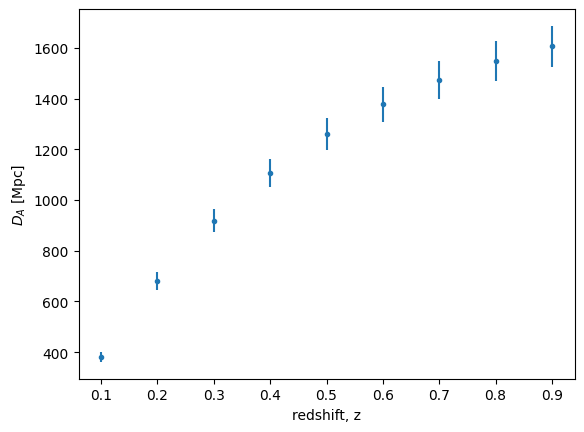

In [6]:
cosmo1=FlatLambdaCDM(H0=70, Om0=0.3)
z=np.arange(0.1,1,0.1)
da_data=cosmo1.angular_diameter_distance(z).value
da_err=0.05*da_data

plt.errorbar(z,da_data,yerr=da_err,fmt='.')
plt.xlabel('redshift, z')
plt.ylabel(r'$D_A$ [Mpc]')

In [7]:
def log_likelihood(theta, da_data, da_err):
    Om, H0 = theta

    cosmo_Om_p=FlatLambdaCDM(H0=H0, Om0=Om)
    da_model_Om_p=cosmo_Om_p.angular_diameter_distance(z).value
    chi2_Om_p=np.sum((da_data-da_model_Om_p)**2/da_err**2)

    return -0.5 * chi2_Om_p

In [8]:
def log_prior(theta):
    Om, H0 = theta
    if 0.1 < Om < 0.5 and 50.0 < H0 < 100.0:
        return 0.0
    return -np.inf

In [27]:
def log_probability(theta, da_data, da_err):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, da_data, da_err)

In [28]:
#initial points
p1=np.random.uniform(low=0.1,high=0.5,size=10)
p2=np.random.uniform(low=50,high=100,size=10)
pos=np.vstack((p1,p2)).T
nwalkers, ndim = pos.shape

In [29]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(da_data, da_err)
)
sampler.run_mcmc(pos, 500, progress=True);

100%|██████████| 500/500 [00:05<00:00, 85.69it/s]


Plot a single chain (notice the Burn-in phase)

Text(0, 0.5, '$H_0$')

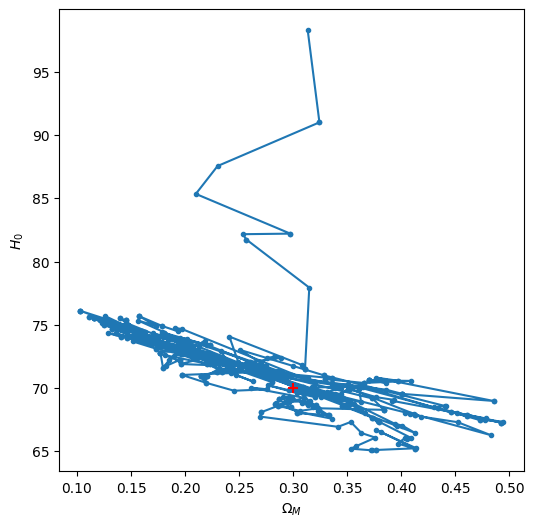

In [51]:
plt.figure(figsize=(6,6))
plt.plot(samples[:,0,0],samples[:,0,1],'.-')
plt.scatter(0.3,70,c='red',marker='+',s=50,zorder=10)
plt.xlabel(r"$\Omega_M$")
plt.ylabel(r"$H_0$")

Plot all chains

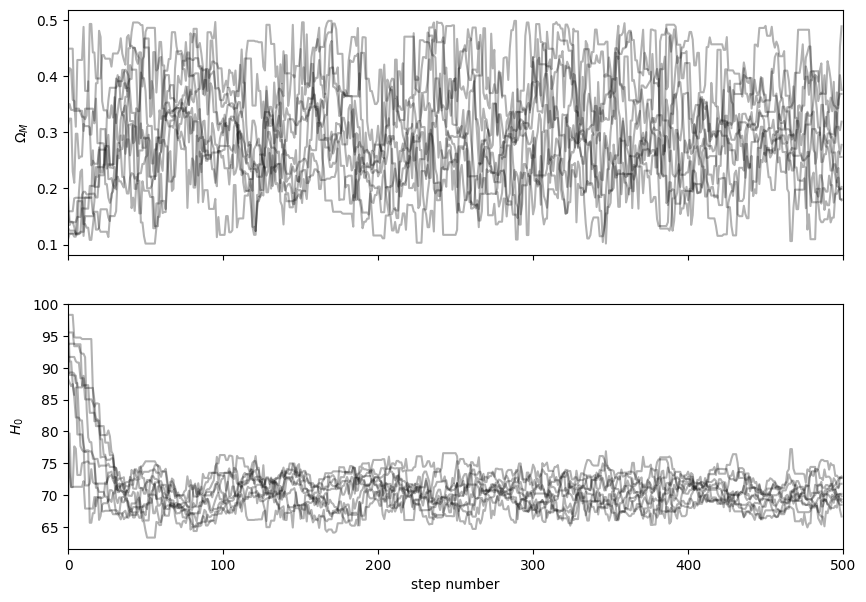

In [61]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['$\Omega_M$','$H_0$',]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    #ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Lets plot the 2D contours

In [53]:
pip install corner

(260, 2)


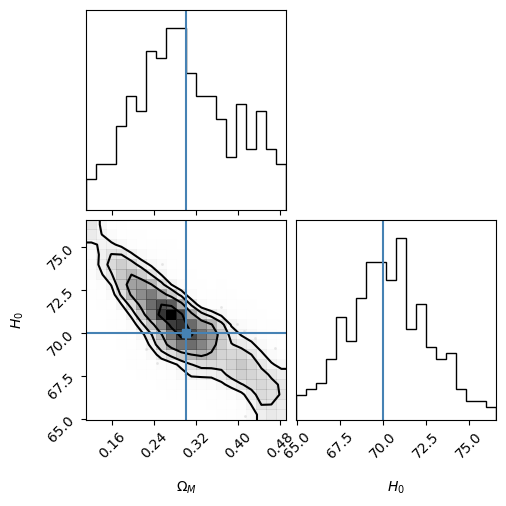

In [60]:
import corner

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

fig = corner.corner(
    flat_samples, labels=['$\Omega_M$','$H_0$'], truths=[0.3,70.], smooth=1.,
);

Lets print or marginalised 1D results with errorbars

In [65]:
from IPython.display import display, Math
labelss=['\Omega_M','H_0']
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labelss[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Q. Can you extend this to 3 parameters, maybe include curvature!